A Tutorial on Autoencoders
====

In this notebook, we briefly experiment with a denoising autoencoder.

## Setup

We import our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from models.autoencoder import Autoencoder

Set eager mode for `tfds`.

In [2]:
tf.compat.v1.enable_eager_execution()

We set our GPU memory growth for efficiency.

In [3]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)


Set the random number generator seed value.

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and the number of epochs.

In [5]:
BATCH_SIZE = 64
EPOCHS = 10

## Dataset

We load the MNIST dataset.

In [6]:
train_dataset = tfds.load("mnist", split=tfds.Split.TRAIN)

We define a normalization function.

In [7]:
def normalize(example):
    features = example["image"]
    features = tf.reshape(features, [-1, 784])
    features = tf.cast(features, tf.float32)
    features = features / 255.
    features = features + tf.random.normal(stddev=5e-1, shape=features.shape)
    return features, features

We customize our `tf.data.Dataset` pipeline.

In [8]:
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(BATCH_SIZE, True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Model

We initialize an autoencoder.

In [9]:
model = Autoencoder()

Call the model once to get a summary.

In [10]:
for batch_features, _ in train_dataset.take(1):
    model(batch_features)
    break

Display the model summary.

In [11]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  108736    
_________________________________________________________________
decoder (Decoder)            multiple                  55120     
Total params: 163,856
Trainable params: 163,856
Non-trainable params: 0
_________________________________________________________________


Compile the model for training.

In [12]:
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=tf.optimizers.Adam(learning_rate=1e-2))

Train the model for 10 epochs.

In [13]:
history = model.fit(train_dataset, epochs=EPOCHS, verbose=2)

Epoch 1/10
937/937 - 5s - loss: 0.2970
Epoch 2/10
937/937 - 5s - loss: 0.2805
Epoch 3/10
937/937 - 5s - loss: 0.2784
Epoch 4/10
937/937 - 5s - loss: 0.2778
Epoch 5/10
937/937 - 5s - loss: 0.2771
Epoch 6/10
937/937 - 5s - loss: 0.2769
Epoch 7/10
937/937 - 5s - loss: 0.2768
Epoch 8/10
937/937 - 5s - loss: 0.2765
Epoch 9/10
937/937 - 5s - loss: 0.2765
Epoch 10/10
937/937 - 5s - loss: 0.2763


Plot the training loss.

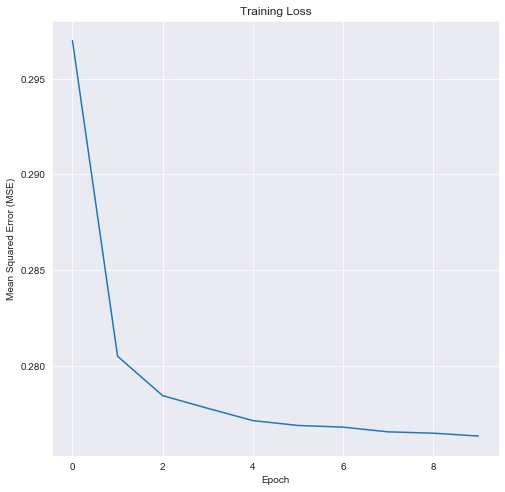

In [14]:
loss = history.history["loss"]

sns.set_style("darkgrid")

plt.figure(figsize=(8, 8))
plt.plot(loss)
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epoch")
plt.title("Training Loss")
plt.show()

Load the test data.

In [15]:
test_dataset = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
test_dataset = tfds.as_numpy(test_dataset)
test_features = test_dataset["image"]
test_features = test_features.astype("float32") / 255.
test_features = test_features + tf.random.normal(stddev=5e-2, shape=test_features.shape)

Visualize the reconstruction and the original data.

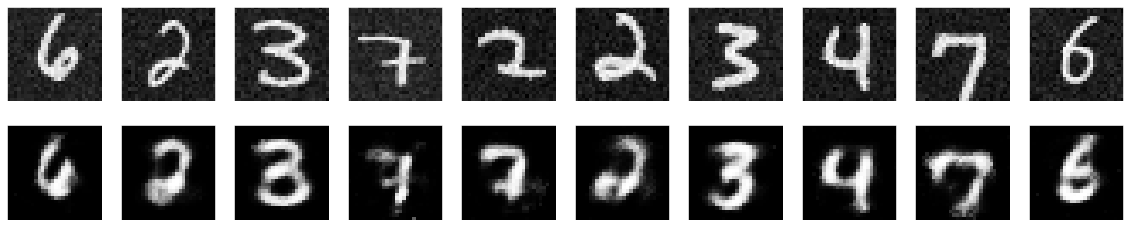

In [16]:
number = 10
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = test_image.numpy().reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_features[index].numpy().reshape(-1, 784))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()